In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense
import joblib

# Step 1: Load CSV file
data = pd.read_csv('/content/FINALLY_SQUAT.csv')

# Step 2: Separate keypoints and labels
keypoints = data.iloc[:, 1:89].values  # Skip the first column (frame name) and take the next 88 columns
correct_label = data['pose-label'].values  # Binary labels: 0 (incorrect), 1 (correct)
error_type = data['error-label'].fillna('None').values  # Error types: None, Too-high-plank, Too-low-plank

# Step 3: Normalize keypoints (Min-Max Scaling)
scaler = MinMaxScaler()
keypoints = scaler.fit_transform(keypoints)

# Step 4: Reshape keypoints to (88, 1) for CNN input
keypoints = keypoints.reshape(-1, 88, 1)

# Step 5: Convert Error Type labels
encoder = LabelEncoder()
error_type_encoded = encoder.fit_transform(error_type)  # Encode error types as integers
error_type_categorical = to_categorical(error_type_encoded)  # One-hot encode for categorical model

# Step 6: Split data into training and testing sets
X_train, X_test, y_train_correct, y_test_correct, y_train_error, y_test_error = train_test_split(
    keypoints, correct_label, error_type_categorical, test_size=0.2, random_state=42
)

# Print data shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train_correct shape: {y_train_correct.shape}")
print(f"y_train_error shape: {y_train_error.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test_correct shape: {y_test_correct.shape}")
print(f"y_test_error shape: {y_test_error.shape}")


X_train shape: (235, 88, 1)
y_train_correct shape: (235,)
y_train_error shape: (235, 3)
X_test shape: (59, 88, 1)
y_test_correct shape: (59,)
y_test_error shape: (59, 3)


CNN

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_correct_incorrect():
    model = models.Sequential([
        layers.Input(shape=(88, 1)),  # 88 keypoints as input
        layers.Conv1D(32, kernel_size=3, activation='relu'),
        layers.Conv1D(64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Binary classification output
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Step 1: Build the model
model_1 = build_cnn_correct_incorrect()

# Step 3: Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history_1 = model_1.fit(
    X_train, y_train_correct,
    validation_data=(X_test, y_test_correct),
    epochs=1000, batch_size=32, callbacks=[early_stopping]
)

model_1.save('/content/cnn_pose-label.keras')

Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.6281 - loss: 0.6686 - val_accuracy: 0.7458 - val_loss: 0.5714
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6177 - loss: 0.6716 - val_accuracy: 0.7458 - val_loss: 0.5756
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6072 - loss: 0.6646 - val_accuracy: 0.7458 - val_loss: 0.5768
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6563 - loss: 0.6186 - val_accuracy: 0.7458 - val_loss: 0.5561
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6629 - loss: 0.6157 - val_accuracy: 0.7627 - val_loss: 0.5730
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6576 - loss: 0.6107 - val_accuracy: 0.7627 - val_loss: 0.5475
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6679 - loss: 0.6043 - val_accuracy: 0.7627 - val_loss: 0.5443
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6971 - loss: 0.5982 - val_accuracy: 0.7458 - v

In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.metrics import AUC

# Model 1 predictions
y_pred_model_1 = model_1.predict(X_test)  # Assuming 'model_1' is the trained model
y_pred_model_1 = (y_pred_model_1 > 0.5)  # If binary classification, otherwise use softmax for multi-class

# Accuracy
accuracy = accuracy_score(y_test_correct, y_pred_model_1)

# Precision
precision = precision_score(y_test_correct, y_pred_model_1)

# Recall
recall = recall_score(y_test_correct, y_pred_model_1)

# F1 Score
f1 = f1_score(y_test_correct, y_pred_model_1)

print(f"Model CNN Evaluation:\n"
      f"Accuracy: {accuracy}\n"
      f"Precision: {precision}\n"
      f"Recall: {recall}\n"
      f"F1 Score: {f1}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step
Model CNN Evaluation:
Accuracy: 0.7796610169491526
Precision: 0.6
Recall: 0.4
F1 Score: 0.48


In [8]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# Updated build model function
def build_cnn_error_classification():
    model = models.Sequential([
        layers.Input(shape=(88, 1)),  # 88 keypoints as input
        layers.Conv1D(32, kernel_size=3, activation='relu'),
        layers.Conv1D(64, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(3, activation='softmax')  # Multi-class classification output (3 classes)
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Filter only incorrect samples for training Model 2
X_train_incorrect = X_train[y_train_correct == 0]
X_test_incorrect = X_test[y_test_correct == 0]
y_train_error_incorrect = y_train_error[y_train_correct == 0]
y_test_error_incorrect = y_test_error[y_test_correct == 0]

# Check and reshape if necessary
print(f"Shape of y_train_error_incorrect before one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect before one-hot encoding: {y_test_error_incorrect.shape}")

# Only apply one-hot encoding if they are not already encoded
if len(y_train_error_incorrect.shape) == 1:
    y_train_error_incorrect = to_categorical(y_train_error_incorrect, num_classes=3)
    y_test_error_incorrect = to_categorical(y_test_error_incorrect, num_classes=3)

# Check shapes after one-hot encoding
print(f"Shape of y_train_error_incorrect after one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect after one-hot encoding: {y_test_error_incorrect.shape}")

# Train the model
model_2 = build_cnn_error_classification()

history_2 = model_2.fit(
    X_train_incorrect, y_train_error_incorrect,
    validation_data=(X_test_incorrect, y_test_error_incorrect),
    epochs=50, batch_size=32
)

# Save the model
model_2.save('/content/cnn_error-label.keras')

Shape of y_train_error_incorrect before one-hot encoding: (153, 3)
Shape of y_test_error_incorrect before one-hot encoding: (44, 3)
Shape of y_train_error_incorrect after one-hot encoding: (153, 3)
Shape of y_test_error_incorrect after one-hot encoding: (44, 3)
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.5011 - loss: 0.9564 - val_accuracy: 0.5227 - val_loss: 0.7130
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5324 - loss: 0.7113 - val_accuracy: 0.6136 - val_loss: 0.6802
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6270 - loss: 0.6802 - val_accuracy: 0.7045 - val_loss: 0.6684
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6645 - loss: 0.6564 - val_accuracy: 0.5227 - val_loss: 0.6599
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5923 - loss: 0.6409 - val_accuracy: 0.5909 - val_loss: 0.6524
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5468 - loss: 0.6412 - val_accuracy: 0.7045 - val_

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


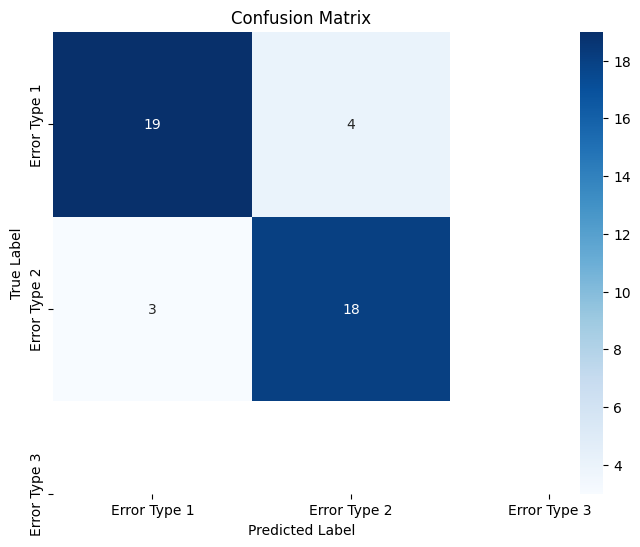

Model CNN Evaluation:
F1 Score for Error Type 1: 0.0
F1 Score for Error Type 2: 0.8444444444444444
F1 Score for Error Type 3: 0.8372093023255814


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert true labels to class indices if they are one-hot encoded
y_test_error_incorrect_class = np.argmax(y_test_error_incorrect, axis=1)

# Model 2 predictions (assuming the model outputs class probabilities)
y_pred_model_2 = model_2.predict(X_test_incorrect)  # Your model's predictions
y_pred_model_2 = np.argmax(y_pred_model_2, axis=1)  # Convert predictions to class indices

# Confusion Matrix
cm = confusion_matrix(y_test_error_incorrect_class, y_pred_model_2)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'],
            yticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# F1-score for each error type (class)
f1_error_1 = f1_score(y_test_error_incorrect_class, y_pred_model_2, labels=[0], average='micro')  # Error Type 1
f1_error_2 = f1_score(y_test_error_incorrect_class, y_pred_model_2, labels=[1], average='micro')  # Error Type 2
f1_error_3 = f1_score(y_test_error_incorrect_class, y_pred_model_2, labels=[2], average='micro')  # Error Type 3

print(f"Model CNN Evaluation:\n"
      f"F1 Score for Error Type 1: {f1_error_1}\n"
      f"F1 Score for Error Type 2: {f1_error_2}\n"
      f"F1 Score for Error Type 3: {f1_error_3}")

CNN with Attention

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_with_attention_correct_incorrect():
    inputs = layers.Input(shape=(88, 1))
    x = layers.Conv1D(32, kernel_size=3, activation='relu')(inputs)
    x = layers.Conv1D(64, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    attention = layers.Attention()([x, x])  # Self-attention
    x = layers.Flatten()(attention)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Step 1: Build the model
model_3 = build_cnn_with_attention_correct_incorrect()

# Step 3: Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history_3 = model_3.fit(
    X_train, y_train_correct,
    validation_data=(X_test, y_test_correct),
    epochs=1000, batch_size=32, callbacks=[early_stopping]
)

model_3.save('/content/cnn-with-attention_pose-label.keras')

Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.6840 - loss: 0.6644 - val_accuracy: 0.7458 - val_loss: 0.6125
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6233 - loss: 0.6714 - val_accuracy: 0.7458 - val_loss: 0.6263
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6802 - loss: 0.6446 - val_accuracy: 0.7458 - val_loss: 0.5755
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6678 - loss: 0.6389 - val_accuracy: 0.7458 - val_loss: 0.5894
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6335 - loss: 0.6620 - val_accuracy: 0.7458 - val_loss: 0.6122
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6597 - loss: 0.6448 - val_accuracy: 0.7458 - val_loss: 0.5886
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6112 - loss: 0.6705 - val_accuracy: 0.7458 - val_loss: 0.5743
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6709 - loss: 0.6350 - val_accuracy: 0.7458 - v

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.metrics import AUC

# Model 1 predictions
y_pred_model_3 = model_3.predict(X_test)  # Assuming 'model_1' is the trained model
y_pred_model_3 = (y_pred_model_3 > 0.5)  # If binary classification, otherwise use softmax for multi-class

# Accuracy
accuracy = accuracy_score(y_test_correct, y_pred_model_3)

# Precision
precision = precision_score(y_test_correct, y_pred_model_3)

# Recall
recall = recall_score(y_test_correct, y_pred_model_3)

# F1 Score
f1 = f1_score(y_test_correct, y_pred_model_3)

print(f"Model CNN with Attention Evaluation:\n"
      f"Accuracy: {accuracy}\n"
      f"Precision: {precision}\n"
      f"Recall: {recall}\n"
      f"F1 Score: {f1}")


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Model CNN with Attention Evaluation:
Accuracy: 0.711864406779661
Precision: 0.25
Recall: 0.06666666666666667
F1 Score: 0.10526315789473684


In [12]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# Updated build model function
def build_cnn_with_attention_error_classification():
    inputs = layers.Input(shape=(88, 1))
    x = layers.Conv1D(32, kernel_size=3, activation='relu')(inputs)
    x = layers.Conv1D(64, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling1D(pool_size=2)(x)
    attention = layers.Attention()([x, x])  # Self-attention
    x = layers.Flatten()(attention)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(2, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Filter only incorrect samples for training Model 2
X_train_incorrect = X_train[y_train_correct == 0]
X_test_incorrect = X_test[y_test_correct == 0]
y_train_error_incorrect = y_train_error[y_train_correct == 0]
y_test_error_incorrect = y_test_error[y_test_correct == 0]

# Check and reshape if necessary
print(f"Shape of y_train_error_incorrect before one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect before one-hot encoding: {y_test_error_incorrect.shape}")

# Only apply one-hot encoding if they are not already encoded
if len(y_train_error_incorrect.shape) == 1:
    y_train_error_incorrect = to_categorical(y_train_error_incorrect, num_classes=3)
    y_test_error_incorrect = to_categorical(y_test_error_incorrect, num_classes=3)

# Check shapes after one-hot encoding
print(f"Shape of y_train_error_incorrect after one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect after one-hot encoding: {y_test_error_incorrect.shape}")

# Train the model
model_4 = build_cnn_error_classification()

history_4 = model_4.fit(
    X_train_incorrect, y_train_error_incorrect,
    validation_data=(X_test_incorrect, y_test_error_incorrect),
    epochs=50, batch_size=32
)

# Save the model
model_4.save('/content/cnn-with-attention_error-label.keras')


Shape of y_train_error_incorrect before one-hot encoding: (153, 3)
Shape of y_test_error_incorrect before one-hot encoding: (44, 3)
Shape of y_train_error_incorrect after one-hot encoding: (153, 3)
Shape of y_test_error_incorrect after one-hot encoding: (44, 3)
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.5136 - loss: 0.9250 - val_accuracy: 0.5227 - val_loss: 0.7045
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5193 - loss: 0.7097 - val_accuracy: 0.5227 - val_loss: 0.6848
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5654 - loss: 0.6791 - val_accuracy: 0.5682 - val_loss: 0.6796
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6519 - loss: 0.6688 - val_accuracy: 0.5682 - val_loss: 0.6665
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6519 - loss: 0.6538 - val_accuracy: 0.6818 - val_loss: 0.6558
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8048 - loss: 0.6331 - val_accuracy: 0.5909 - val_

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step


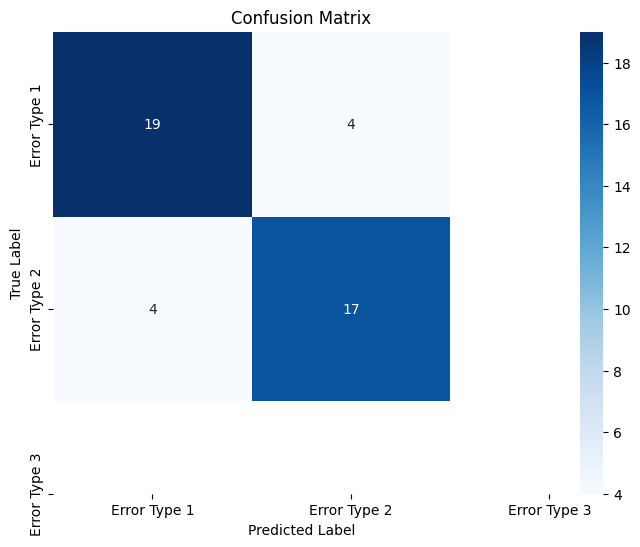

Model CNN with Attention Evaluation:
F1 Score for Error Type 1: 0.0
F1 Score for Error Type 2: 0.8260869565217391
F1 Score for Error Type 3: 0.8095238095238095


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert true labels to class indices if they are one-hot encoded
y_test_error_incorrect_class = np.argmax(y_test_error_incorrect, axis=1)

# Model 2 predictions (assuming the model outputs class probabilities)
y_pred_model_4 = model_4.predict(X_test_incorrect)  # Your model's predictions
y_pred_model_4 = np.argmax(y_pred_model_4, axis=1)  # Convert predictions to class indices

# Confusion Matrix
cm = confusion_matrix(y_test_error_incorrect_class, y_pred_model_4)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'],
            yticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# F1-score for each error type (class)
f1_error_1 = f1_score(y_test_error_incorrect_class, y_pred_model_4, labels=[0], average='micro')  # Error Type 1
f1_error_2 = f1_score(y_test_error_incorrect_class, y_pred_model_4, labels=[1], average='micro')  # Error Type 2
f1_error_3 = f1_score(y_test_error_incorrect_class, y_pred_model_4, labels=[2], average='micro')  # Error Type 3

print(f"Model CNN with Attention Evaluation:\n"
      f"F1 Score for Error Type 1: {f1_error_1}\n"
      f"F1 Score for Error Type 2: {f1_error_2}\n"
      f"F1 Score for Error Type 3: {f1_error_3}")

VGG

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers, models

def build_vgg_correct_incorrect():
    model = models.Sequential([
        layers.Input(shape=(88, 1)),
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Step 1: Build the model
model_5 = build_vgg_correct_incorrect()

# Step 3: Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history_5 = model_5.fit(
    X_train, y_train_correct,
    validation_data=(X_test, y_test_correct),
    epochs=1000, batch_size=32, callbacks=[early_stopping]
)

model_5.save('/content/vgg_pose-label.keras')

Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.6442 - loss: 0.6789 - val_accuracy: 0.7458 - val_loss: 0.6185
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6531 - loss: 0.6484 - val_accuracy: 0.7458 - val_loss: 0.5815
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6817 - loss: 0.6235 - val_accuracy: 0.7458 - val_loss: 0.6062
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6629 - loss: 0.6421 - val_accuracy: 0.7458 - val_loss: 0.5851
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6729 - loss: 0.6265 - val_accuracy: 0.7458 - val_loss: 0.5848
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.6200 - loss: 0.6454 - val_accuracy: 0.7458 - val_loss: 0.5475
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6858 - loss: 0.5946 - val_accuracy: 0.7627 - val_loss: 0.5886
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7002 - loss: 0.6080 - val_accuracy: 0.7458 - v

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.metrics import AUC

# Model 1 predictions
y_pred_model_5 = model_5.predict(X_test)  # Assuming 'model_1' is the trained model
y_pred_model_5 = (y_pred_model_5 > 0.5)  # If binary classification, otherwise use softmax for multi-class

# Accuracy
accuracy = accuracy_score(y_test_correct, y_pred_model_5)

# Precision
precision = precision_score(y_test_correct, y_pred_model_5)

# Recall
recall = recall_score(y_test_correct, y_pred_model_5)

# F1 Score
f1 = f1_score(y_test_correct, y_pred_model_5)

print(f"Model VGG Evaluation:\n"
      f"Accuracy: {accuracy}\n"
      f"Precision: {precision}\n"
      f"Recall: {recall}\n"
      f"F1 Score: {f1}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Model VGG Evaluation:
Accuracy: 0.6949152542372882
Precision: 0.2857142857142857
Recall: 0.13333333333333333
F1 Score: 0.18181818181818182


In [16]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

# Updated build model function
def build_vgg_error_classification():
    model = models.Sequential([
        layers.Input(shape=(88, 1)),
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Filter only incorrect samples for training Model 2
X_train_incorrect = X_train[y_train_correct == 0]
X_test_incorrect = X_test[y_test_correct == 0]
y_train_error_incorrect = y_train_error[y_train_correct == 0]
y_test_error_incorrect = y_test_error[y_test_correct == 0]

# Check and reshape if necessary
print(f"Shape of y_train_error_incorrect before one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect before one-hot encoding: {y_test_error_incorrect.shape}")

# Only apply one-hot encoding if they are not already encoded
if len(y_train_error_incorrect.shape) == 1:
    y_train_error_incorrect = to_categorical(y_train_error_incorrect, num_classes=3)
    y_test_error_incorrect = to_categorical(y_test_error_incorrect, num_classes=3)

# Check shapes after one-hot encoding
print(f"Shape of y_train_error_incorrect after one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect after one-hot encoding: {y_test_error_incorrect.shape}")

# Train the model
model_6 = build_vgg_error_classification()

history_6 = model_6.fit(
    X_train_incorrect, y_train_error_incorrect,
    validation_data=(X_test_incorrect, y_test_error_incorrect),
    epochs=50, batch_size=32
)

# Save the model
model_6.save('/content/vgg_error-label.keras')


Shape of y_train_error_incorrect before one-hot encoding: (153, 3)
Shape of y_test_error_incorrect before one-hot encoding: (44, 3)
Shape of y_train_error_incorrect after one-hot encoding: (153, 3)
Shape of y_test_error_incorrect after one-hot encoding: (44, 3)
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.5002 - loss: 0.9455 - val_accuracy: 0.4773 - val_loss: 0.7962
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4663 - loss: 0.7921 - val_accuracy: 0.5227 - val_loss: 0.6911
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4763 - loss: 0.7074 - val_accuracy: 0.4773 - val_loss: 0.7259
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4389 - loss: 0.7258 - val_accuracy: 0.5227 - val_loss: 0.7087
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5884 - loss: 0.7031 - val_accuracy: 0.5227 - val_loss: 0.6946
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5193 - loss: 0.6935 - val_accuracy: 0.4773 - val_l

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 267ms/step


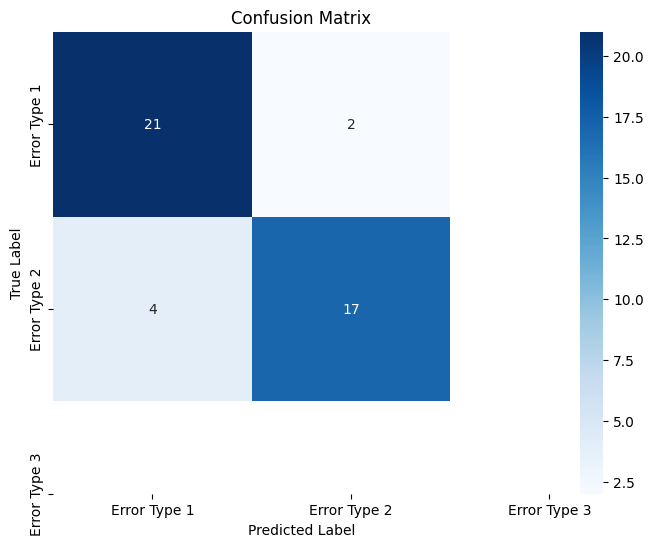

Model VGG Evaluation:
F1 Score for Error Type 1: 0.0
F1 Score for Error Type 2: 0.875
F1 Score for Error Type 3: 0.85


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert true labels to class indices if they are one-hot encoded
y_test_error_incorrect_class = np.argmax(y_test_error_incorrect, axis=1)

# Model 2 predictions (assuming the model outputs class probabilities)
y_pred_model_6 = model_6.predict(X_test_incorrect)  # Your model's predictions
y_pred_model_6 = np.argmax(y_pred_model_6, axis=1)  # Convert predictions to class indices

# Confusion Matrix
cm = confusion_matrix(y_test_error_incorrect_class, y_pred_model_6)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'],
            yticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# F1-score for each error type (class)
f1_error_1 = f1_score(y_test_error_incorrect_class, y_pred_model_6, labels=[0], average='micro')  # Error Type 1
f1_error_2 = f1_score(y_test_error_incorrect_class, y_pred_model_6, labels=[1], average='micro')  # Error Type 2
f1_error_3 = f1_score(y_test_error_incorrect_class, y_pred_model_6, labels=[2], average='micro')  # Error Type 3

print(f"Model VGG Evaluation:\n"
      f"F1 Score for Error Type 1: {f1_error_1}\n"
      f"F1 Score for Error Type 2: {f1_error_2}\n"
      f"F1 Score for Error Type 3: {f1_error_3}")

Transformer


In [18]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

def build_transformer_correct_incorrect():
    inputs = layers.Input(shape=(88, 1))

    # Pass through a dense layer before the attention layer
    x = layers.Dense(64, activation='relu')(inputs)

    # Add Multi-Head Attention layer
    attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)

    # Add a residual connection and layer normalization
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization()(x)

    # Apply Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Define and compile the model
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Step 1: Build the model
model_7 = build_transformer_correct_incorrect()

# Step 2: Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Step 3: Train the model
history_7 = model_7.fit(
    X_train, y_train_correct,
    validation_data=(X_test, y_test_correct),
    epochs=1000, batch_size=32, callbacks=[early_stopping]
)

# Save the trained model
model_7.save('/content/transformer_pose-label.keras')


Epoch 1/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.5485 - loss: 0.7214 - val_accuracy: 0.7458 - val_loss: 0.6243
Epoch 2/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6672 - loss: 0.6493 - val_accuracy: 0.7458 - val_loss: 0.5791
Epoch 3/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6581 - loss: 0.6428 - val_accuracy: 0.7458 - val_loss: 0.6042
Epoch 4/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6468 - loss: 0.6525 - val_accuracy: 0.7458 - val_loss: 0.5792
Epoch 5/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6530 - loss: 0.6489 - val_accuracy: 0.7458 - val_loss: 0.5963
Epoch 6/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6512 - loss: 0.6524 - val_accuracy: 0.7458 - val_loss: 0.5902
Epoch 7/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6137 - loss: 0.6692 - val_accuracy: 0.7458 - val_loss: 0.5750
Epoch 8/1000
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6937 - loss: 0.6182 - val_accuracy: 0.7458 - v

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.metrics import AUC

# Model 1 predictions
y_pred_model_7 = model_7.predict(X_test)  # Assuming 'model_1' is the trained model
y_pred_model_7 = (y_pred_model_7 > 0.5)  # If binary classification, otherwise use softmax for multi-class

# Accuracy
accuracy = accuracy_score(y_test_correct, y_pred_model_7)

# Precision
precision = precision_score(y_test_correct, y_pred_model_7)

# Recall
recall = recall_score(y_test_correct, y_pred_model_7)

# F1 Score
f1 = f1_score(y_test_correct, y_pred_model_7)

print(f"Model Transformer Evaluation:\n"
      f"Accuracy: {accuracy}\n"
      f"Precision: {precision}\n"
      f"Recall: {recall}\n"
      f"F1 Score: {f1}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Model Transformer Evaluation:
Accuracy: 0.7457627118644068
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

def build_transformer_error_classification():
    inputs = layers.Input(shape=(88, 1))

    # Pass through a dense layer before the attention layer
    x = layers.Dense(64, activation='relu')(inputs)

    # Add Multi-Head Attention layer
    attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=32)(x, x)

    # Add a residual connection and layer normalization
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization()(x)

    # Apply Global Average Pooling
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(3, activation='softmax')(x)  # Adjust to 3 output classes

    # Define and compile the model
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Filter only incorrect samples for training Model 2
X_train_incorrect = X_train[y_train_correct == 0]
X_test_incorrect = X_test[y_test_correct == 0]
y_train_error_incorrect = y_train_error[y_train_correct == 0]
y_test_error_incorrect = y_test_error[y_test_correct == 0]

# Check and reshape if necessary
print(f"Shape of y_train_error_incorrect before one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect before one-hot encoding: {y_test_error_incorrect.shape}")

# Only apply one-hot encoding if they are not already encoded
if len(y_train_error_incorrect.shape) == 1:
    y_train_error_incorrect = to_categorical(y_train_error_incorrect, num_classes=3)
    y_test_error_incorrect = to_categorical(y_test_error_incorrect, num_classes=3)

# Check shapes after one-hot encoding
print(f"Shape of y_train_error_incorrect after one-hot encoding: {y_train_error_incorrect.shape}")
print(f"Shape of y_test_error_incorrect after one-hot encoding: {y_test_error_incorrect.shape}")

# Train the model
model_8 = build_transformer_error_classification()

# early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history_8 = model_8.fit(
    X_train_incorrect, y_train_error_incorrect,
    validation_data=(X_test_incorrect, y_test_error_incorrect),
    epochs=50, batch_size=32
)

# Save the model
model_8.save('/content/transformer_error-label.keras')


Shape of y_train_error_incorrect before one-hot encoding: (153, 3)
Shape of y_test_error_incorrect before one-hot encoding: (44, 3)
Shape of y_train_error_incorrect after one-hot encoding: (153, 3)
Shape of y_test_error_incorrect after one-hot encoding: (44, 3)
Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - accuracy: 0.4845 - loss: 0.8663 - val_accuracy: 0.5227 - val_loss: 0.7066
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.5437 - loss: 0.7062 - val_accuracy: 0.4773 - val_loss: 0.7062
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.4506 - loss: 0.7113 - val_accuracy: 0.5227 - val_loss: 0.7027
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.5841 - loss: 0.6810 - val_accuracy: 0.4773 - val_loss: 0.7105
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.5045 - loss: 0.7117 - val_accuracy: 0.5227 - val_loss: 0.6923
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.4950 - loss: 0.6989 - val_accuracy: 0.5227 - va

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step


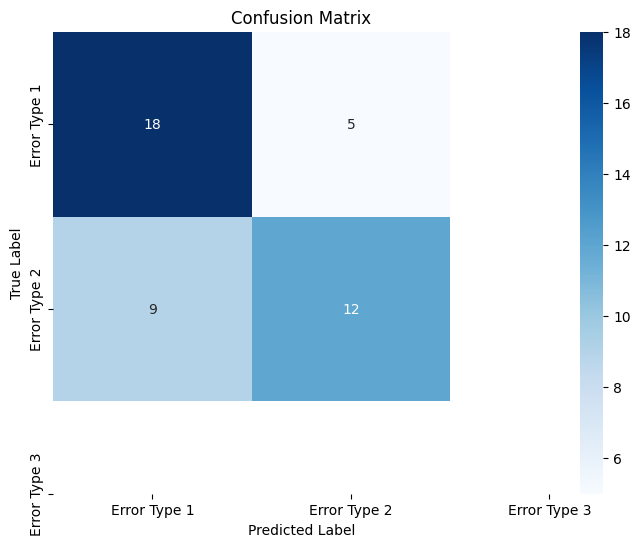

Model Transformer Evaluation:
F1 Score for Error Type 1: 0.0
F1 Score for Error Type 2: 0.72
F1 Score for Error Type 3: 0.631578947368421


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert true labels to class indices if they are one-hot encoded
y_test_error_incorrect_class = np.argmax(y_test_error_incorrect, axis=1)

# Model 2 predictions (assuming the model outputs class probabilities)
y_pred_model_8 = model_8.predict(X_test_incorrect)  # Your model's predictions
y_pred_model_8 = np.argmax(y_pred_model_8, axis=1)  # Convert predictions to class indices

# Confusion Matrix
cm = confusion_matrix(y_test_error_incorrect_class, y_pred_model_8)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'],
            yticklabels=['Error Type 1', 'Error Type 2', 'Error Type 3'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# F1-score for each error type (class)
f1_error_1 = f1_score(y_test_error_incorrect_class, y_pred_model_8, labels=[0], average='micro')  # Error Type 1
f1_error_2 = f1_score(y_test_error_incorrect_class, y_pred_model_8, labels=[1], average='micro')  # Error Type 2
f1_error_3 = f1_score(y_test_error_incorrect_class, y_pred_model_8, labels=[2], average='micro')  # Error Type 3

print(f"Model Transformer Evaluation:\n"
      f"F1 Score for Error Type 1: {f1_error_1}\n"
      f"F1 Score for Error Type 2: {f1_error_2}\n"
      f"F1 Score for Error Type 3: {f1_error_3}")